In [73]:
!nvidia-smi

Wed Nov 27 22:28:24 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P0              29W /  70W |    421MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [74]:
import torch
import torch.nn as nn
import numpy as np

In [75]:
def shuffle_columns(tensor, indices):
    return tensor[:, indices]

In [76]:
N = 10 # Sequence length
n_train = 2000  # Batch size
vocab_size = 10 #vocab_size

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Generate a batch of random input sequences
input_sequences = torch.randint(0, vocab_size, (n_train, N)) #n x N

A = torch.eye(N).long()

perm = torch.randperm(N)
A = shuffle_columns(A, perm) #generates a random permutation
print(A)

output_sequences  = torch.matmul(input_sequences, A)
print(torch.max(output_sequences))

tensor([[0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]])
tensor(9)


In [77]:
train_input_sequences = input_sequences.to(device)
train_output_sequences = output_sequences.to(device)

In [78]:
n_test = 400
val_input_sequences = torch.randint(0, vocab_size, (n_test, N))
val_output_sequences = torch.matmul(val_input_sequences, A)

val_input_sequences = val_input_sequences.to(device)
val_output_sequences = val_output_sequences.to(device)

In [79]:
class PointwiseFeedforwardNetwork(nn.Module):
  def __init__(self, d_embed, d_ff):
    super(PointwiseFeedforwardNetwork, self).__init__()
    self.d_embed = d_embed
    self.d_ff = d_ff

    self.ffn1 = nn.Linear(d_embed, d_ff)
    self.ffn2 = nn.Linear(d_ff, d_embed)

    self.relu = nn.ReLU()

  def forward(self, x):
    return self.ffn2(self.relu(self.ffn1(x)))

In [80]:
class Attention(nn.Module):
  def __init__(self, d_embed):
    super(Attention, self).__init__()

    self.d_embed = d_embed
    self.query_proj = nn.Linear(d_embed, d_embed).to(device)
    self.key_proj = nn.Linear(d_embed, d_embed).to(device)
    self.value_proj = nn.Linear(d_embed, d_embed).to(device)


  def forward(self, x):
    Q = self.query_proj(x)
    K = self.key_proj(x)
    V = self.value_proj(x)

    scores = torch.matmul(Q, K.transpose(2, 1)) / (self.d_embed ** 0.5)

    attention_weights = torch.softmax(scores, dim=-1)

    output = torch.matmul(attention_weights, V)

    return output


In [81]:
class TransformerLayer(nn.Module):
  def __init__(self, d_embed, d_ff):
    super(TransformerLayer, self).__init__()
    self.d_embed = d_embed
    self.d_ff = d_ff

    self.attn = Attention(self.d_embed)

    self.norm1 = nn.LayerNorm(d_embed).to(device)
    self.norm2 = nn.LayerNorm(d_embed).to(device)
    self.dropout = nn.Dropout(0.1)

    self.ffn = PointwiseFeedforwardNetwork(d_embed, d_ff).to(device)
    self.ffout = nn.Linear(d_embed, d_embed).to(device)

  def forward(self, x):
    x = self.norm1(x + self.dropout(self.attn(x)))
    ffn = self.ffn(x)
    x = self.norm2(x + self.dropout(ffn))

    return self.ffout(x)


In [82]:
class MultiLayerTransformer(nn.Module):
  def __init__(self, d_embed, vocab_size, d_ff, num_layers):
    super(MultiLayerTransformer, self).__init__()
    self.embed = nn.Embedding(vocab_size, d_embed).to(device)
    self.layers = nn.ModuleList([TransformerLayer(d_embed, d_ff)] * num_layers)
    self.fcout = nn.Linear(d_embed, vocab_size).to(device)

  def forward(self, x):
    x_embed = self.embed(x)

    for layer in self.layers:
      x_embed = layer(x_embed)

    return self.fcout(x_embed)

In [83]:
class RNN(nn.Module):
  def __init__(self, d_embed, vocab_size, hidden_dim, num_layers):
    super().__init__()
    self.size_vocab = vocab_size
    self.d_embed = d_embed

    self.embed = nn.Embedding(vocab_size, d_embed).to(device)
    self.rnn = nn.RNN(d_embed, hidden_dim, num_layers= num_layers, dropout=0.1, batch_first=True).to(device)
    self.fc = nn.Linear(hidden_dim, vocab_size).to(device)

  def forward(self, x):
    x_embed = self.embed(x) # (n, N, embed_dim)
    x_rnn, _ = self.rnn(x_embed) # (n, N, hidden_dim)
    out = self.fc(x_rnn) # (n, N, size_vocab)
    return out

In [84]:
def epoch_evaluate(X_val, y_val, vocab_size, model, criterion):
    model.eval()
    with torch.no_grad():
      predictions = model(X_val).to(device)
      loss = criterion(predictions.contiguous().view(-1, vocab_size), y_val.contiguous().view(-1))
      return loss.item()

In [85]:
def train(vocab_size, model, criterion, optimizer, epochs, X_train, y_train, X_val, y_val):
  losses = []
  val_losses = []
  for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()

    outputs = model(X_train)

    loss = criterion(outputs.contiguous().view(-1, vocab_size), y_train.contiguous().view(-1))
    losses.append(loss.item())

    loss.backward()
    optimizer.step()

    val_loss = epoch_evaluate(X_val, y_val, vocab_size, model, criterion)
    val_losses.append(val_loss)


    if (epoch+1) % 10 == 0:
      print(f'Epoch [{epoch+1}/{epochs}], Training loss: {loss:.4f}, Validation loss: {val_loss:.4f}')

  return losses, val_losses


In [86]:
d_ff = 32
d_embed = 32
num_layers = 3

trans = MultiLayerTransformer(d_embed, vocab_size, d_ff, num_layers).to(device)
optimizer_trans = torch.optim.Adam(trans.parameters())
num_trainable_params = sum([p.numel() for p in trans.parameters()])
print("# param Transformer:", num_trainable_params)

rnn = RNN(d_embed, vocab_size, d_ff, num_layers).to(device)
optimizer_rnn = torch.optim.Adam(rnn.parameters())
num_trainable_params = sum([p.numel() for p in rnn.parameters()])
print("# param RNN:", num_trainable_params)

criterion = nn.CrossEntropyLoss().to(device)
epochs = 5000


# param Transformer: 7114
# param RNN: 6986


In [87]:
trans_train_loss, trans_losses = train(vocab_size, trans, criterion, optimizer_trans, epochs, train_input_sequences, train_output_sequences, val_input_sequences, val_output_sequences)

Epoch [10/5000], Training loss: 2.2465, Validation loss: 2.2484
Epoch [20/5000], Training loss: 2.1767, Validation loss: 2.1853
Epoch [30/5000], Training loss: 2.1141, Validation loss: 2.1242
Epoch [40/5000], Training loss: 2.0596, Validation loss: 2.0693
Epoch [50/5000], Training loss: 2.0119, Validation loss: 2.0218
Epoch [60/5000], Training loss: 1.9704, Validation loss: 1.9848
Epoch [70/5000], Training loss: 1.9341, Validation loss: 1.9536
Epoch [80/5000], Training loss: 1.9037, Validation loss: 1.9259
Epoch [90/5000], Training loss: 1.8883, Validation loss: 1.9090
Epoch [100/5000], Training loss: 1.8764, Validation loss: 1.9000
Epoch [110/5000], Training loss: 1.8721, Validation loss: 1.8949
Epoch [120/5000], Training loss: 1.8657, Validation loss: 1.8902
Epoch [130/5000], Training loss: 1.8585, Validation loss: 1.8862
Epoch [140/5000], Training loss: 1.8549, Validation loss: 1.8819
Epoch [150/5000], Training loss: 1.8502, Validation loss: 1.8780
Epoch [160/5000], Training loss: 1

In [88]:
criterion = nn.CrossEntropyLoss().to(device)
rnn_train_loss, rnn_losses = train(vocab_size, rnn, criterion, optimizer_rnn, epochs, train_input_sequences, train_output_sequences, val_input_sequences, val_output_sequences)

Epoch [10/5000], Training loss: 2.2808, Validation loss: 2.2784
Epoch [20/5000], Training loss: 2.2455, Validation loss: 2.2440
Epoch [30/5000], Training loss: 2.2156, Validation loss: 2.2159
Epoch [40/5000], Training loss: 2.1910, Validation loss: 2.1950
Epoch [50/5000], Training loss: 2.1681, Validation loss: 2.1778
Epoch [60/5000], Training loss: 2.1499, Validation loss: 2.1633
Epoch [70/5000], Training loss: 2.1345, Validation loss: 2.1504
Epoch [80/5000], Training loss: 2.1209, Validation loss: 2.1366
Epoch [90/5000], Training loss: 2.1082, Validation loss: 2.1242
Epoch [100/5000], Training loss: 2.0964, Validation loss: 2.1137
Epoch [110/5000], Training loss: 2.0827, Validation loss: 2.1041
Epoch [120/5000], Training loss: 2.0712, Validation loss: 2.0941
Epoch [130/5000], Training loss: 2.0573, Validation loss: 2.0840
Epoch [140/5000], Training loss: 2.0442, Validation loss: 2.0735
Epoch [150/5000], Training loss: 2.0344, Validation loss: 2.0654
Epoch [160/5000], Training loss: 2

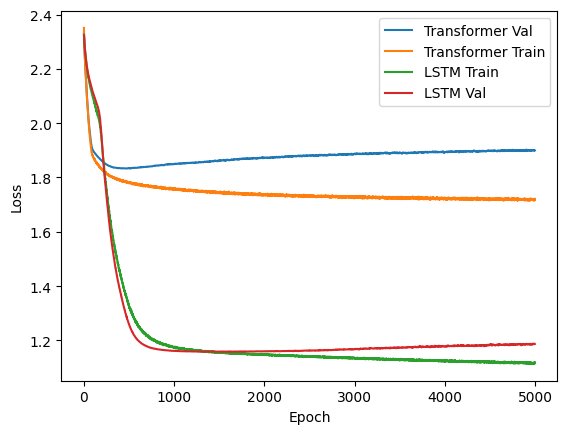

In [89]:
import matplotlib.pyplot as plt

plt.plot(trans_losses, label= "Transformer Val")
plt.plot(trans_train_loss, label= "Transformer Train")
plt.plot(rnn_train_loss, label = "LSTM Train")
plt.plot(rnn_losses, label = "LSTM Val")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()